<a href="https://colab.research.google.com/github/Umesh27/OpenCV_Learning/blob/master/Modified_Weather_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Import necessary libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.models import vgg16
from torch.utils.data import DataLoader, random_split, ConcatDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm

In [4]:
import copy

In [5]:

# Check device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
import os
folder_path = '/content/drive/My Drive/OpenCV_Exercise/weather_data'
files = os.listdir(folder_path)
print(files)

['shine', 'cloudy', 'sunrise', 'rain']


In [7]:
import random

In [8]:
# Preload all file lists to avoid repeated calls to os.listdir()
# Dataset folder path
data_dir = folder_path #f'/content/drive/My Drive/OpenCV_Exercise/weather_data'
categories = ['cloudy', 'rain', 'shine', 'sunrise']
category_files = {cat: os.listdir(f'{folder_path}/{cat}') for cat in categories}
# category_files

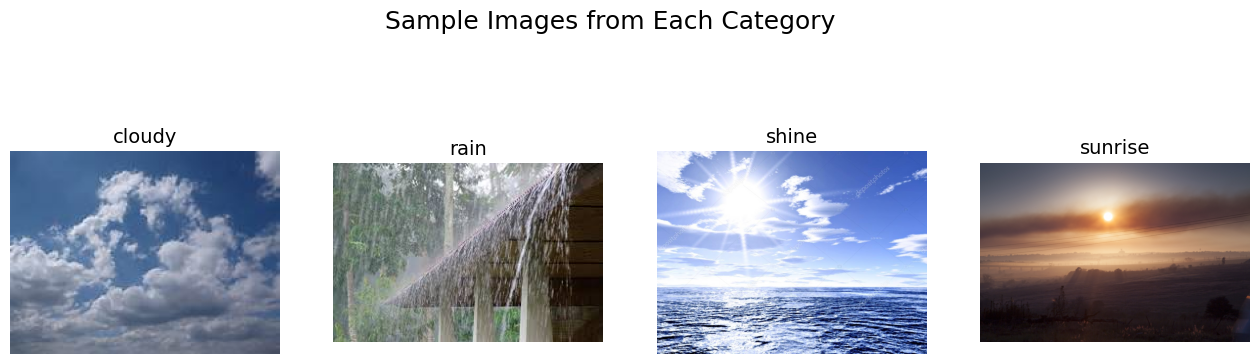

In [9]:
# # Displaying sample images
# sample_images = [Image.open(f'{data_dir}/{cat}/{random.sample(os.listdir(f"{folder_path}/{cat}"), 1)[0]}') for cat in categories]
# Select random images for each category using preloaded file lists
sample_images = [Image.open(f'{folder_path}/{cat}/{random.choice(category_files[cat])}') for cat in categories]
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
for i, ax in enumerate(axs):
    ax.imshow(sample_images[i])
    ax.set_title(categories[i], fontsize=14)
    ax.axis('off')
plt.suptitle("Sample Images from Each Category", fontsize=18)
plt.show()

801 1602 171 173


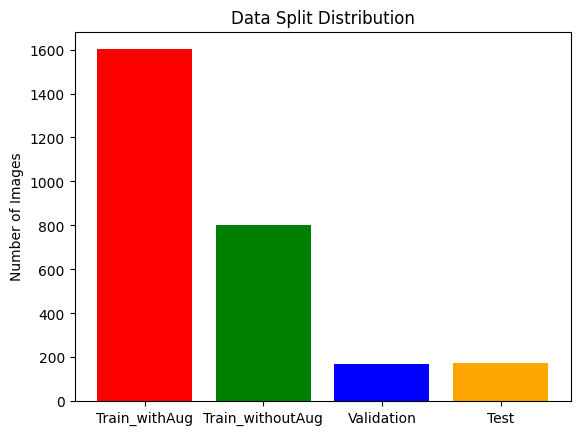

In [10]:
# Data transformations (increased variety)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Splitting dataset into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Data augmentation for training set
augmentation_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets with augmentation
augmented_train_data = copy.deepcopy(train_data)
augmented_train_data.dataset.transform = augmentation_transforms
final_train_data = ConcatDataset([train_data, augmented_train_data])
print(len(train_data), len(final_train_data), len(val_data), len(test_data))

# Visualization: dataset distribution
dataset_counts = [len(final_train_data), len(train_data), len(val_data), len(test_data)]
plt.bar(['Train_withAug', 'Train_withoutAug', 'Validation', 'Test'], dataset_counts, color=['red', 'green', 'blue', 'orange'])
plt.title('Data Split Distribution')
plt.ylabel('Number of Images')
plt.show()

In [11]:
# Custom CNN based on VGG16 for weather classification
class WeatherClassifier(nn.Module):
    def __init__(self):
        super(WeatherClassifier, self).__init__()
        self.vgg = vgg16(pretrained=True).features
        self.fc1 = nn.Linear(512*7*7, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.vgg(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return nn.Softmax(dim=1)(x)

In [12]:

# Initialize model, loss, and optimizer
model = WeatherClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]


In [13]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_loss, val_acc = validate_model(model, val_loader)

        history['train_loss'].append(running_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    return history


# Validation function
def validate_model(model, val_loader):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    return val_loss / len(val_loader), val_acc

In [14]:
epochs = 200

# Dataloaders
batch_size = 128
train_loader = DataLoader(final_train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Train the model
history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=epochs)

# Visualization: Training Curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [3, 256, 256] at entry 0 and [3, 224, 224] at entry 3

In [ ]:
# Test the model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.show()

In [1]:
# Classification Report
print(classification_report(all_labels, all_preds, target_names=categories))


Mounted at /content/drive
